### Import Dependencies

In [4]:
import h5py
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras.utils import np_utils
from keras import utils

#### avoid oom errors by setting gpu memory consumption growth

In [5]:
# grab all the gpus available in the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
# for every gpu set memory growth (making tensorflow to keep the memory only to what it needs)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Dataset

I will be using the Galaxy10 SDSS Dataset from [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The dataset can be found here: http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5  
The dataset contains 21785 69x69 pixels colored galaxy images separated in 10 classes as shown below:  

Galaxy10 dataset (21785 images)  
├── Class 0 (3461 images): Disk, Face-on, No Spiral  
├── Class 1 (6997 images): Smooth, Completely round  
├── Class 2 (6292 images): Smooth, in-between round  
├── Class 3 (394 images): Smooth, Cigar shaped  
├── Class 4 (1534 images): Disk, Edge-on, Rounded Bulge  
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge  
├── Class 6 (589 images): Disk, Edge-on, No Bulge  
├── Class 7 (1121 images): Disk, Face-on, Tight Spiral  
├── Class 8 (906 images): Disk, Face-on, Medium Spiral  
└── Class 9 (519 images): Disk, Face-on, Loose Spiral  

Images come from [Sloan Digital Sky Survey](https://www.sdss.org/) and labels from [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/).

In [6]:
# get the images and labels from file
with h5py.File('dataset/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# convert to desirable type
labels = labels.astype(np.uint8)
images = images.astype(np.uint8)

### Visualize Dataset

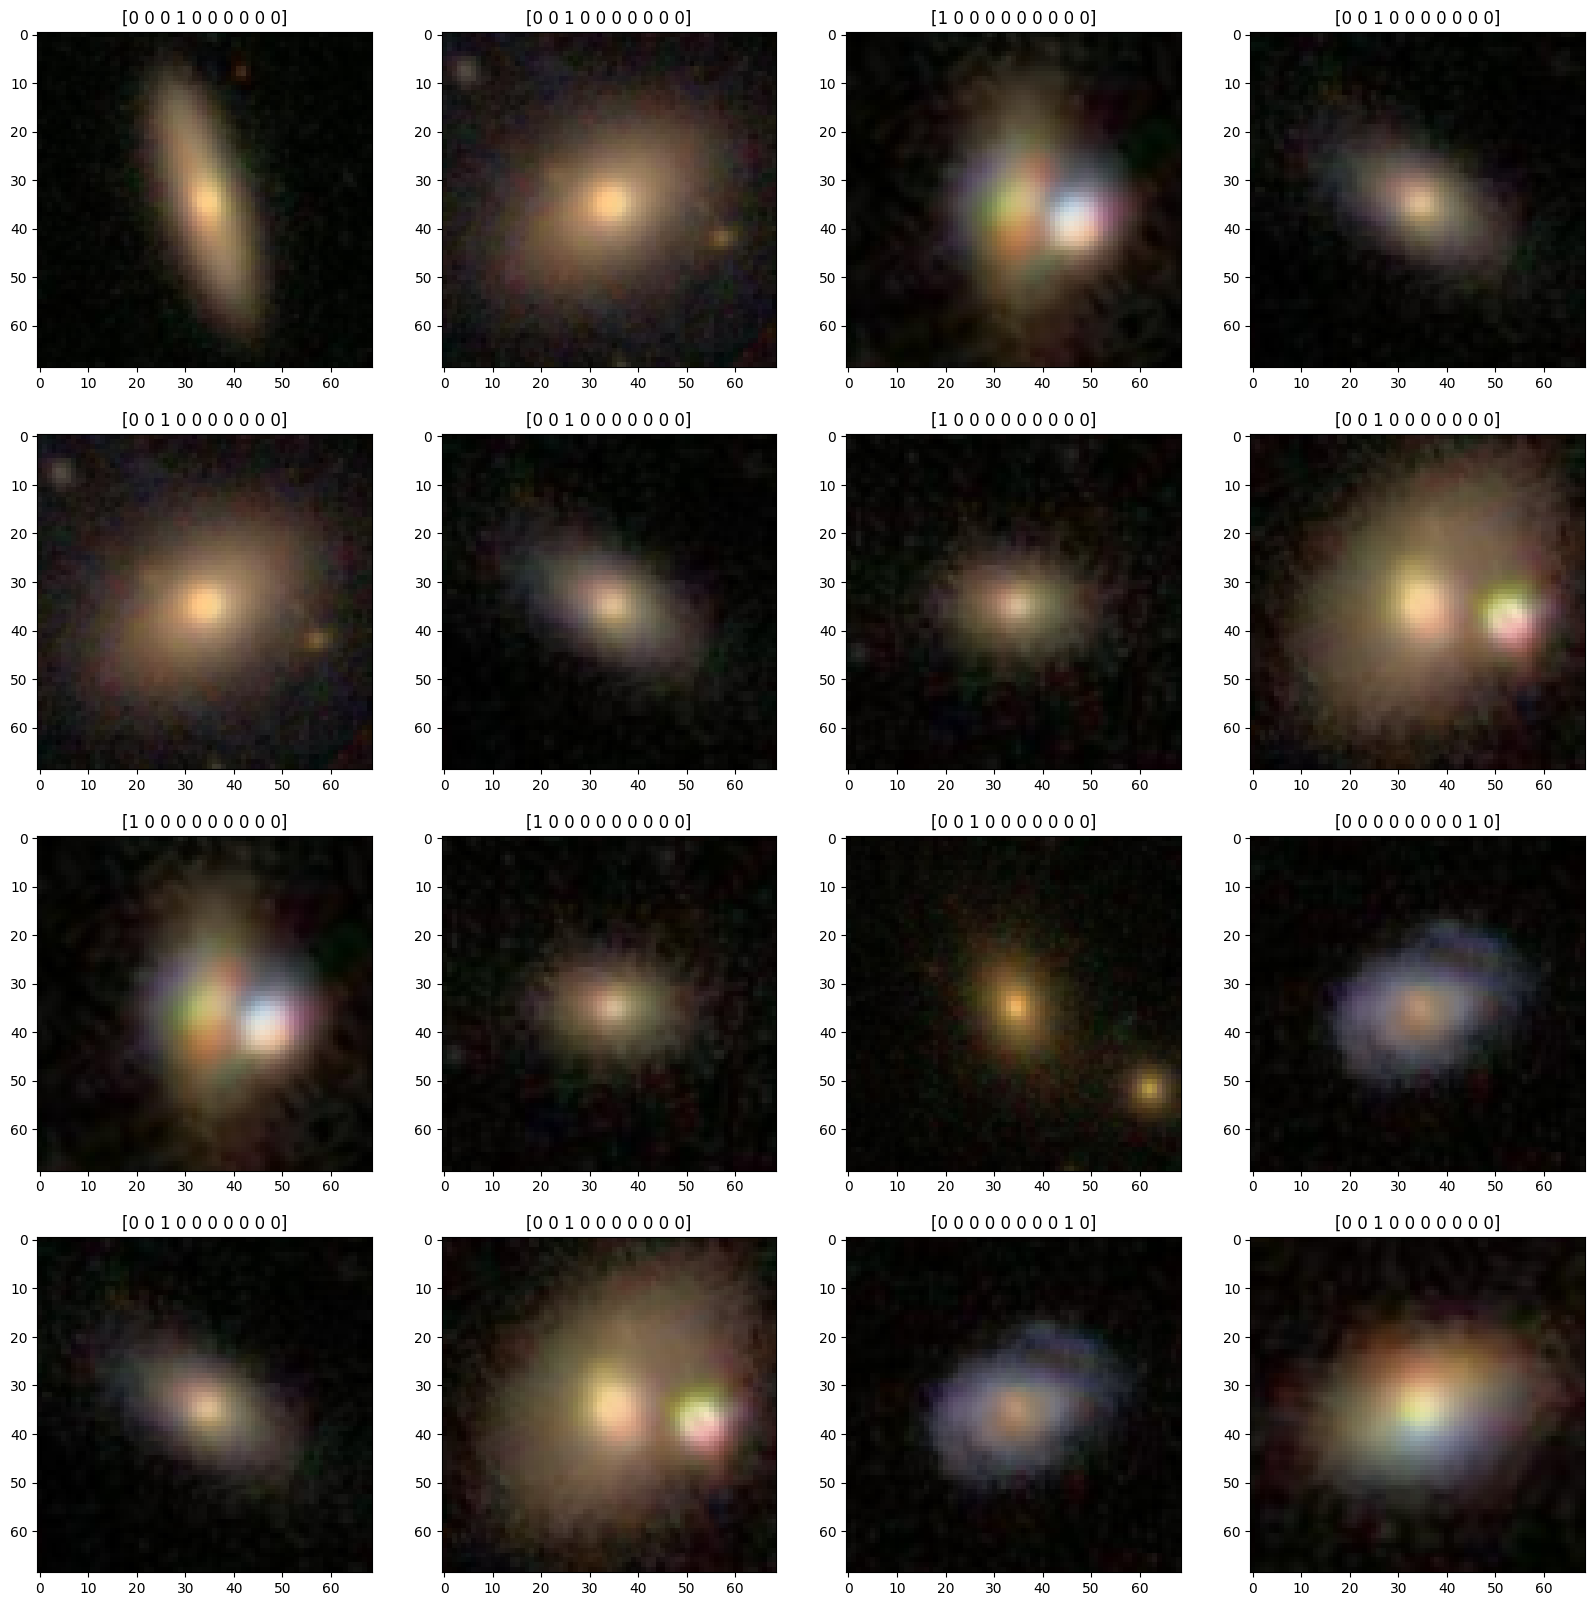

In [7]:
# get 16 random images
num_images = images.shape[0]
random_images = random.sample(range(num_images), 16)
# get their corresponding labels
img = images[random_images]
random_labels = [str(label) for label in labels[random_images]]

# visualize them
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(img[(i+1)*(j+1)-1])
        ax[i][j].title.set_text(random_labels[(i+1)*(j+1)-1])
plt.show()

### Preprocess the images

In [8]:
def preprocess_images(image):
    # resize the image to 68x68
    image = tf.image.resize(image, size=(68, 68))
    # scale the image
    image = image / 255
    # return the processed image
    return image

#### cache/shuffle/batch/prefetch

In [9]:
# Convert the numpy array to a `tf.data.Dataset` object
images = tf.data.Dataset.from_tensor_slices(images)

# run images through the preprocess function
images = images.map(preprocess_images)
# cache images for that batch
images = images.cache()
# shuffle the images
images = images.shuffle(60000)
# batch them into 128 images per sample
images = images.batch(128)
# reduces the likelihood of bottlenecking
images = images.prefetch(64)

### Build the Generator

In the GAN model we need a generator. The generator's purpose is to take random noise as input and generate new samples that are similar to the training data (meaning our images from the dataset). By doing so the generator can then fool the discriminator (which we will also build later) into thinking they are real data samples. The goal is for the generator to "compete" with the discriminator and over time both of them get better and better. If the generator is not able to "fool" the discriminator it means that the sample is not very realistic and needs further improvement.

In [10]:
# Load the modeling components
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [11]:
def build_generator():
    model = Sequential()                       # define our model
    model.add(Dense(17*17*128, input_dim=128)) # add Dense layer with random noise as input
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation
    model.add(Reshape((17,17,128)))            # reshape to 17*17*128

    # Upsampling block - 1
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Upsampling block - 2
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 1
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 2
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # convolutional nn layer to change to 3 channels,kernel size 4x4, same padding and a sigmoid activation this time
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))

    # return the model
    return model

#### Generator summary

In [12]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36992)             4771968   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36992)             0         
                                                                 
 reshape (Reshape)           (None, 17, 17, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 34, 34, 128)       0         
                                                        

#### test the generator

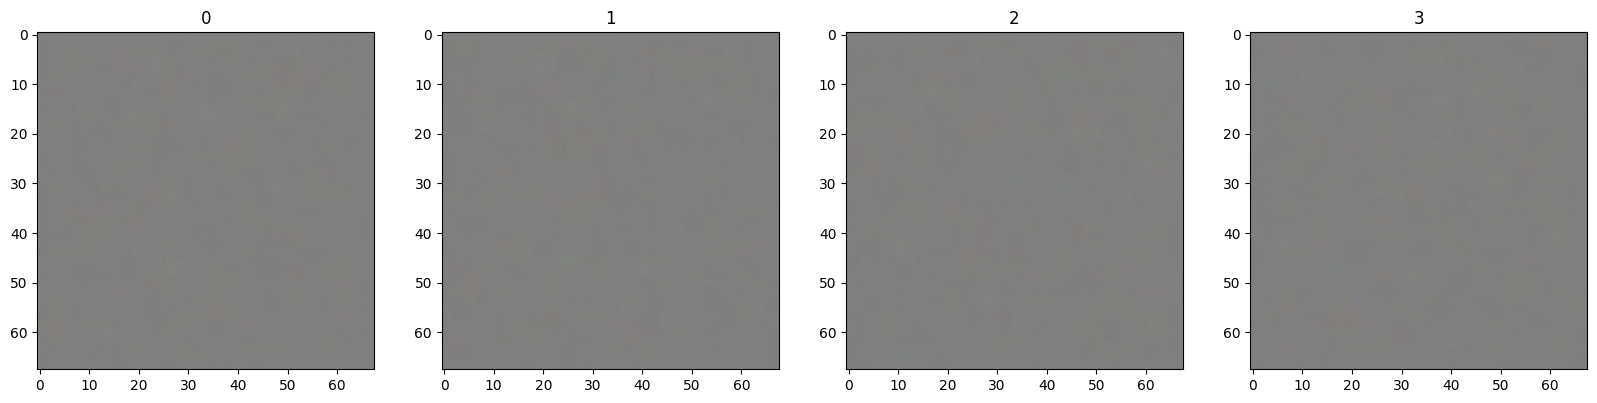

In [13]:
# generate 4 random images
imgs = generator.predict(np.random.randn(4, 128), verbose=0)
# get data out of the pipeline and visualize
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# loop through images
for idx, img in enumerate(imgs):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### Build the Discriminator

In the GAN model we also need a discriminator. The discriminator's purpose is distinguishing between the generated (meaning the fake images) and the real images. It is trained to classify images as either real or fake and its feedback is used to train the generator and produce even better images. By training them simultaneously the GAN model is able to generate better and better images over time.

In [14]:
def build_discriminator():
    model = Sequential()                            # define our model

    # convolutional block - 1
    model.add(Conv2D(32, 5, input_shape=(68,68,3))) # convolutional nn layer with 32 units, kernel size 5x5 and input size of our data
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # convolutional block - 2
    model.add(Conv2D(64, 5))                        # convolutional nn layer with 64 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)
 
    # convolutional block - 3
    model.add(Conv2D(128, 5))                       # convolutional nn layer with 128 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # convolutional block - 4
    model.add(Conv2D(128, 5))                       # convolutional nn layer with 128 units, kernel size 5x5
    model.add(LeakyReLU(0.2))                       # apply LeakyRelu activation
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)

    # flatten and then pass to one Dense layer
    model.add(Flatten())                            # Flattens output (takes the output of the last convolutional layer and converts from 3D tensor to 1D tensor)
    model.add(Dropout(0.4))                         # apply Dropout for reguralizaion (prevents overfitting)
    model.add(Dense(1, activation='sigmoid'))       # Dense layer for final decision based on the features learned by the previous layers (1 for false image and 0 for real image)

    # return the model
    return model

#### Discriminator summary

In [15]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 60, 60, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 128)      

#### test the discriminator

In [16]:
# use discriminator to make predictions on the 4 generated images from earlier
discriminator.predict(imgs, verbose=0)

array([[0.48035976],
       [0.48036492],
       [0.48022583],
       [0.48009166]], dtype=float32)

### Custom training loop

In [17]:
# Load the training loop components
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model

In [18]:
# Adam optimizers for generator and discriminator (determine how quickly the weights of the model are updated during training)
gen_opt = Adam(learning_rate=0.0001)  # learning rate for generator optimizer set to 0.0001
dis_opt = Adam(learning_rate=0.00001) # learning rate for discriminator optimizer set to 0.00001

# Losses for generator and discriminator (measure how well the model is performing)
gen_loss = BinaryCrossentropy()
dis_loss = BinaryCrossentropy()

In [19]:
# Build subclassed model
class galaxyGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # create attributes for generator and discriminator
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, gen_opt, dis_opt, gen_loss, dis_loss, *args, **kwargs):
        # compile with base class
        super().compile(*args, **kwargs)
        # create attributes for losses and optimizers
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss
    
    # Train step
    def train_step(self, batch):
        # get data
        real_img = batch
        fake_img = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train discriminator
        with tf.GradientTape() as dis_tape:
            # pass real and fake images to discriminator
            real = self.discriminator(real_img, training=True)                                  # get real images
            fake = self.discriminator(fake_img, training=True)                                  # get fake images
            real_fake = tf.concat([real, fake], axis=0)                                         # concatenates the output of the discriminator for fake and real images as a single tensor

            # create labels for real and fake images (0 for real and 1 for fake)
            real_fake_labels = tf.concat([tf.zeros_like(real), tf.ones_like(fake)], axis=0)

            # add some noise to the outputs (to prevent overfitting and improve the generalization performance of the model)
            noise_real = 0.15*tf.random.uniform(tf.shape(real))                                 # 0.15 for real samples (swifted up)
            noise_fake = -0.15*tf.random.uniform(tf.shape(fake))                                # -0.15 for fake samples (swifted down)
            real_fake_labels = tf.concat([noise_real, noise_fake], axis=0)                      # concatenates the output of the real and fake noise as a single tensor

            # calcualte loss
            total_dis_loss = self.dis_loss(real_fake_labels, real_fake)

            # apply backpropagation (allow NN to learn)
            disgrad = dis_tape.gradient(total_dis_loss, self.discriminator.trainable_variables) # computes the gradients of the total discriminator loss with respect to its trainable variables
            self.dis_opt.apply_gradients(zip(disgrad, self.discriminator.trainable_variables))  # apply the computed gradients to the discriminator's trainable variables using the optimizer
        
        # Train generator
        with tf.GradientTape() as gen_tape:
            # generate some new images
            gen_img = self.generator(tf.random.normal((128, 128, 1)), training=True)            # creates a tensor of shape (128,128,1) and passes it to the generator network
            pred_labels = self.discriminator(gen_img, training=False)                           # gets the predicted values for the generated images (if they are fake or real)
            total_gen_loss = self.gen_loss(tf.zeros_like(pred_labels), pred_labels)             # calculates generator's loss 
        
        # apply backpropagation (allow NN to learn)
        gengrad = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)         # computes the gradients of the total generator loss with respect to its trainable variables
        self.gen_opt.apply_gradients(zip(gengrad, self.generator.trainable_variables))          # apply the computed gradients to the generator's trainable variables using the optimizer

        # return losses
        return {'discriminator loss':total_dis_loss, 'generator loss':total_gen_loss}
    
    # Test step
    def test_step(self):
        pass

In [20]:
# create an instant of the GAN
galaxygan = galaxyGAN(generator, discriminator)

# compile the model (specify the optimizer and loss functions for both generator and discriminator)
galaxygan.compile(gen_opt, dis_opt, gen_loss, dis_loss)

### Callback function

In [21]:
# Load the callback components
import os
from keras.utils import array_to_img
from keras.callbacks import Callback

In [22]:
# The call back function allows us to save examples of our generated images as we are training
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # generate random values
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        # pass to generator
        generated_images = self.model.generator(random_latent_vectors)
        # generate bunch of images
        generated_images *= 255
        # convert them to a numpy array
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### Train the model

In [23]:
# train the GAN with 1 epochs and our callback function (alot more epochs needed for a good model, ideally 2000)
hist = galaxygan.fit(images, epochs=1, callbacks=[ModelMonitor()], verbose=1)

 11/171 [>.............................] - ETA: 1:50:04 - discriminator loss: 0.3848 - generator loss: 0.3137


KeyboardInterrupt



### Plot the losses

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['dis_loss'], label='dis_loss')
plt.plot(hist.history['gen_loss'], label='gen_loss')
plt.legend()
plt.show()